In [109]:
!pip install fastai --upgrade -q
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [110]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Tabular Data
## Das Datenset
Datenset einer [Kaggle Competition](https://www.kaggle.com/c/bluebook-for-bulldozers)

In [111]:
# Direkter Download von IBM Bucket
!wget https://welcome2ki-tabulardata-bulldozer-auction-kaggle.s3.eu-de.cloud-object-storage.appdomain.cloud/bluebook-for-bulldozers.zip

--2020-12-02 08:07:33--  https://welcome2ki-tabulardata-bulldozer-auction-kaggle.s3.eu-de.cloud-object-storage.appdomain.cloud/bluebook-for-bulldozers.zip
Resolving welcome2ki-tabulardata-bulldozer-auction-kaggle.s3.eu-de.cloud-object-storage.appdomain.cloud (welcome2ki-tabulardata-bulldozer-auction-kaggle.s3.eu-de.cloud-object-storage.appdomain.cloud)... 158.177.118.97
Connecting to welcome2ki-tabulardata-bulldozer-auction-kaggle.s3.eu-de.cloud-object-storage.appdomain.cloud (welcome2ki-tabulardata-bulldozer-auction-kaggle.s3.eu-de.cloud-object-storage.appdomain.cloud)|158.177.118.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50792941 (48M) [application/zip]
Saving to: ‘bluebook-for-bulldozers.zip.1’

bluebook-for-bulldo 100%[===================>]  48.44M  48.1MB/s    in 1.0s    

2020-12-02 08:07:35 (48.1 MB/s) - ‘bluebook-for-bulldozers.zip.1’ saved [50792941/50792941]



In [112]:
path = Path()
path.ls()

(#20) [Path('.config'),Path('Train.7z'),Path('Valid.zip'),Path('TrainAndValid.7z'),Path('gdrive'),Path('median_benchmark.csv'),Path('random_forest_benchmark_test.csv'),Path('Valid.7z'),Path('TrainAndValid.zip'),Path('Valid.csv')...]

In [113]:
Path.BASE_PATH = path

In [114]:
file_extract(path/'bluebook-for-bulldozers.zip')

In [115]:
path.ls(file_type='text')

(#7) [Path('median_benchmark.csv'),Path('random_forest_benchmark_test.csv'),Path('Valid.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv'),Path('Test.csv'),Path('TrainAndValid.csv')]

Folgende Spalten sind in der [Beschreibung](https://www.kaggle.com/c/bluebook-for-bulldozers/data) von `train.csv` enthalten:

* SalesID
* MachineID
* saleprice
* saledate

In [116]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

### Kardinale Datenspalten

In [117]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [118]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [119]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [120]:
dep_var = 'SalePrice'

In [121]:
df[dep_var] = np.log(df[dep_var])

# Decision Tree

![DecisionTrees](https://upload.wikimedia.org/wikipedia/commons/f/ff/Decision_tree_model.png)

Quelle: MediaWiki

## Behandlung der Datumsfelder

In [122]:
df = add_datepart(df, 'saledate')

In [123]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [124]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleWeek saleYear saleMonth saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [125]:
??add_datepart

## TabularPandas und TabularProc

In [126]:
procs = [Categorify, FillMissing]

In [127]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [128]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [129]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [130]:
len(to.train),len(to.valid)

(404710, 7988)

In [131]:
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [132]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [133]:
to.items.head(3)

,SalesID,SalePrice,MachineID,saleWeek,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,46,...,1,2647,1,1
1,1139248,10.950807,117657,13,...,1,2148,1,1
2,1139249,9.210340,434808,9,...,1,2131,1,1


In [134]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [135]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

## Erstellen des Decision Trees

In [136]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [137]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

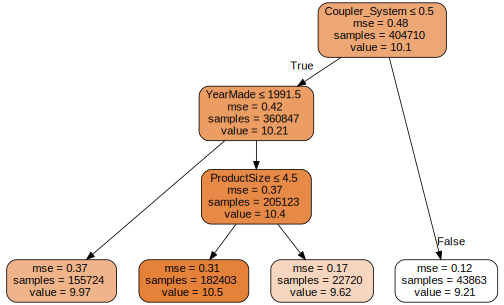

In [138]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

Visualisierung mithilfe von Terence Parr's powerful [dtreeviz library](https://explained.ai/decision-tree-viz/).

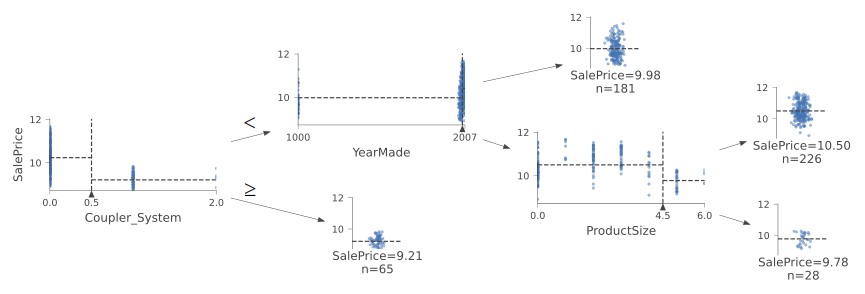

In [139]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [140]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

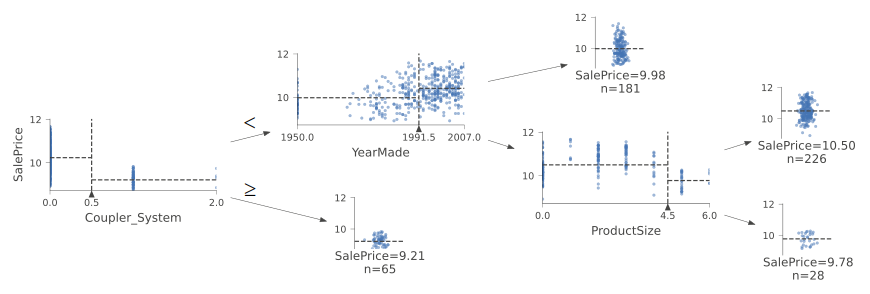

In [141]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [142]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [143]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [144]:
m_rmse(m, xs, y)

1e-06

In [145]:
m_rmse(m, valid_xs, valid_y)

0.332804

In [146]:
m.get_n_leaves(), len(xs)

(324554, 404710)

In [147]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248563, 0.323432)

In [148]:
m.get_n_leaves()

12397

# Random Forests

In [149]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [150]:
m = rf(xs, y);

In [151]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171054, 0.232339)

In [152]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [153]:
r_mse(preds.mean(0), valid_y)

0.232339

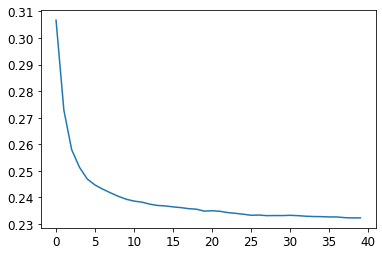

In [154]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

## Der Out-Of-Bag Fehler
Im Random Forest trainieren wir jeden einzelnen Entscheidungsbaum auf Basis eines unterschiedlichen Subsamples der verfügbaren Trainingsdaten.

Mithilfe des _Out-Of-Bag_-Fehlers berechnen wir den Validationloss nur anhand von Datenelementen, die nicht Teil des jeweiligen Subsamples des einzelnen Entscheidungsbaum waren.

In [155]:
r_mse(m.oob_prediction_, y)

0.210921

## Modell Interpretation

### Varianz des Random Forest

In [156]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [157]:
preds.shape

(40, 7988)

In [158]:
preds_std = preds.std(0)

In [159]:
preds_std[:5]

array([0.24712662, 0.10315303, 0.11900946, 0.2335968 , 0.12299923])

### Relevanz der einzelnen Spalten

In [160]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [161]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
59,YearMade,0.178015
7,ProductSize,0.122043
31,Coupler_System,0.103273
8,fiProductClassDesc,0.076147
33,Hydraulics_Flow,0.074350
56,ModelID,0.053669
51,saleElapsed,0.051364
4,fiSecondaryDesc,0.047496
2,fiModelDesc,0.030244
32,Grouser_Tracks,0.026853


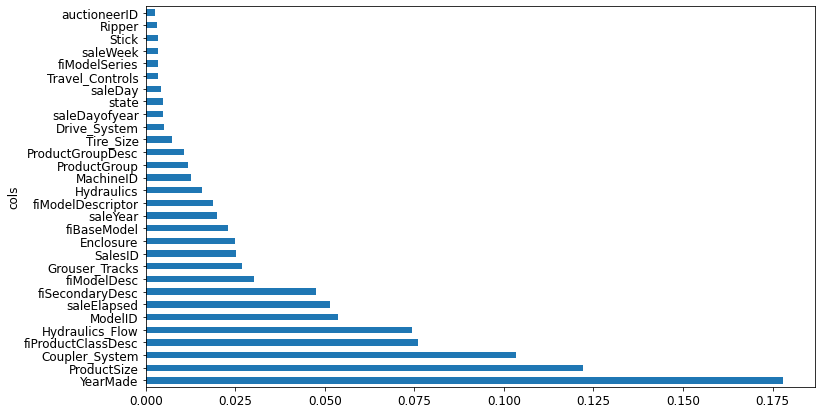

In [162]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Features mit geringer Wichtigkeit entfernen

In [163]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [164]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [165]:
m = rf(xs_imp, y)

In [166]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181384, 0.232149)

In [167]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

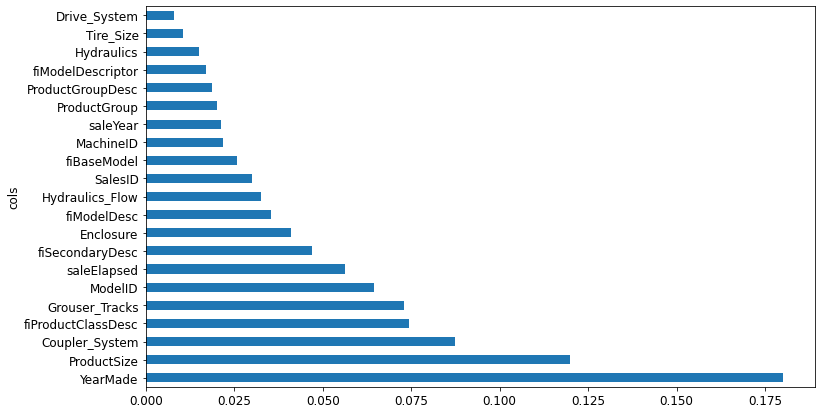

In [168]:
plot_fi(rf_feat_importance(m, xs_imp));

### Redundante Spalten entfernen

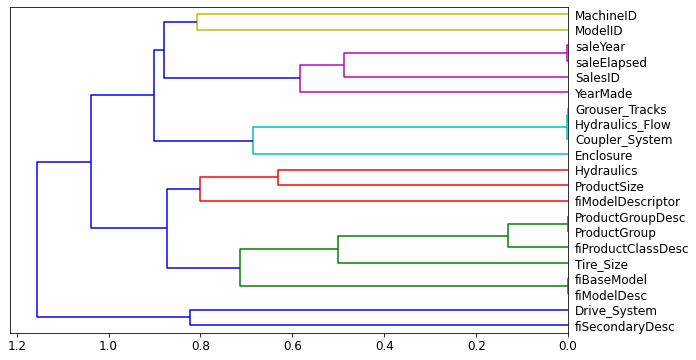

In [169]:
cluster_columns(xs_imp)

In [170]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [171]:
get_oob(xs_imp)

0.8771001335474721

In [172]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'Coupler_System': 0.8765028810589007,
 'Grouser_Tracks': 0.8779875905752396,
 'Hydraulics_Flow': 0.8779818302732787,
 'ProductGroup': 0.8773152245185344,
 'ProductGroupDesc': 0.8783721787930077,
 'fiBaseModel': 0.8763229912837079,
 'fiModelDesc': 0.8757973502691581,
 'saleElapsed': 0.8728490500733916,
 'saleYear': 0.8764151636732002}

In [173]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8746690814436842

In [174]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [175]:
# save data for reloading later
#(path/'xs_final.pkl').save(xs_final)
#(path/'valid_xs_final.pkl').save(valid_xs_final)

In [176]:
# reload data
#xs_final = (path/'xs_final.pkl').load()
#valid_xs_final = (path/'valid_xs_final.pkl').load()

In [177]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183206, 0.2322)

### Abhängigkeit zwischen Features

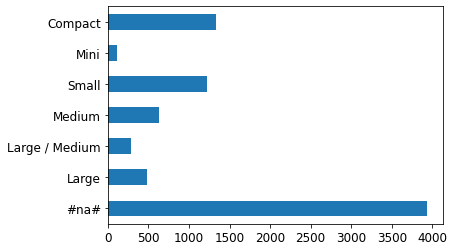

In [178]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

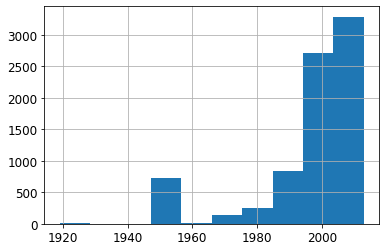

In [179]:
ax = valid_xs_final['YearMade'].hist()

**Plotten der teilweisen Abhängigkeit:** Wenn ich die Werte aller Features gleich lasse und nur *(in unserem Fall)* das Feature `YearMade` verändere, wie verändert sich die Gesamtprognose?

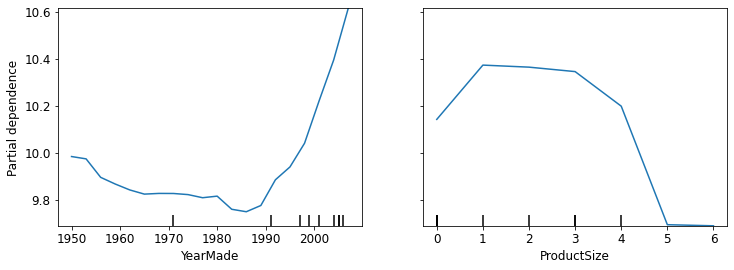

In [180]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

## Der Baum Interpreter
Mithilfe der Interpretation unseres Baums und der Visualisierung (module `treeinterpreter` und `waterfall`) wollen wir folgende Fragen beantworten:

1. Wie hoch ist unser Vertrauen in die Prognose in Bezug auf eine bestimmte Zeile in unseren Daten?
1. Welche sind die wichtigsten Faktoren zur Generierung einer Prognose und wie haben diese die Prognose unseres Modells beeinflusst - wenn wir eine einzelne Zeile unserer Daten betrachten?
1. Welche Spalten sind die relevantesten Prognosefaktoren?
1. Welche Spalten sind im Endeffekt redundant (hinsichtlicher Prognose unseres Modells?
1. Wie verändert sich die Prognose, wenn wir diese Spalten verändern?

In [181]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [182]:
row = valid_xs_final.iloc[:5]

In [183]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [184]:
prediction[0], bias[0], contributions[0].sum()

(array([9.97665483]), 10.104458105856775, -0.1278032731892233)

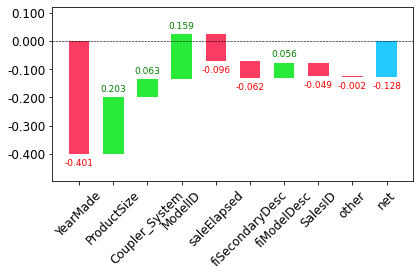

In [185]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

# Extrapolation und neuronale Netzwerke

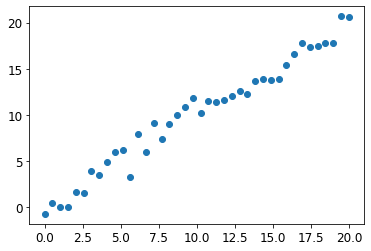

In [186]:
np.random.seed(42)
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [187]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [188]:
x_lin[:,None].shape

torch.Size([40, 1])

In [189]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

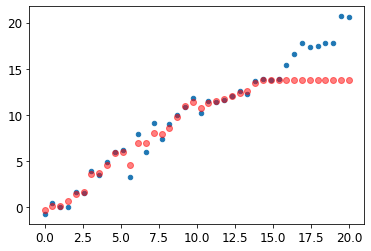

In [190]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

## Auffinden von _Out-of-Domain_-Daten

In [191]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.885153
9,SalesID,0.092150
13,MachineID,0.017598
0,YearMade,0.001374
15,Tire_Size,0.000640
5,ModelID,0.000613


In [192]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232534
SalesID 0.230909
saleElapsed 0.235694
MachineID 0.230581


In [193]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.2288

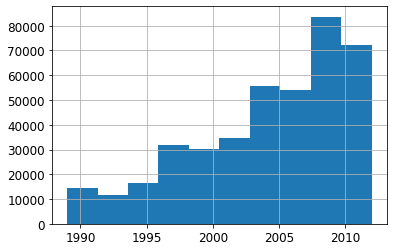

In [194]:
xs['saleYear'].hist();

In [195]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [196]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177668, 0.228662)

# Verwendung eines neuronale Netzes

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [ ]:
df_nn_final = (df_nn[list(xs_final_time.columns) + [dep_var]]).copy()

In [197]:
df_nn_final.dtypes

YearMade                 int64
ProductSize           category
Coupler_System          object
fiProductClassDesc      object
Hydraulics_Flow         object
ModelID                  int64
saleElapsed              int64
fiSecondaryDesc         object
fiModelDesc             object
Enclosure               object
Hydraulics              object
ProductGroup            object
fiModelDescriptor       object
Drive_System            object
Tire_Size               object
SalePrice              float64
dtype: object

In [ ]:
df_nn_final.saleElapsed = df_nn_final.saleElapsed.astype('int')

In [198]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [199]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

In [200]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
Hydraulics_Flow          3
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
Hydraulics              12
ProductGroup             6
fiModelDescriptor      140
Drive_System             4
Tire_Size               17
dtype: int64

In [97]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176853, 0.229973)

In [ ]:
cat_nn.remove('fiModelDescriptor')

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(1024)

In [101]:
y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

In [ ]:
from fastai.tabular.all import *

In [ ]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

### Ensembling und Boosting

In [107]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [108]:
r_mse(ens_preds,valid_y)

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567

0.221567